<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Adaptation_Domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Le but de ce projet est de faire tourner le code de Rémy FLAMARY disponible ici https://github.com/rflamary/JDOT et ensuite de le faire tourner sur un jeu de donnée de mon choix.**

Installation des bibliothèques

In [ ]:
pip install numpy scipy matplotlib POT # keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 19.8 MB/s eta 0:00:00


In [ ]:
!pip install scipy==1.13.1

In [ ]:
!pip install --upgrade gensim

# **1- Dans cette première partie on utilise le code de Rémy tel qu'il l'a écrit avec ses données**

In [ ]:
from google.colab import files
files.upload()

Saving jdot.py to jdot.py
Saving classif.py to classif.py


{'jdot.py': b'# -*- coding: utf-8 -*-\n"""\nCreated on Thu Sep 21 16:59:10 2017\n\n@author: rflamary\n"""\n\n# Author: Remi Flamary <remi.flamary@unice.fr>\n#         Nicolas Courty <ncourty@irisa.fr>\n#\n# License: MIT License\n\nimport numpy as np\nfrom scipy.spatial.distance import cdist \nimport classif\nimport sklearn\nimport ot\n\n#from sklearn import datasets\n\n\n# X: source domain\n# y: source labeks\n# Xtest: target domain\n# ytest is optionnal, just to measure performances of the method along iterations\n# gamma: RBF kernel param (default=1)\n# numIterBCD: number of Iterations for BCD (default=10)\n# alpha: ponderation between ground cost + function cost\n# method: choice of algorithm for transport computation (default: emd)\n\n\ndef jdot_krr(X,y,Xtest,gamma_g=1, numIterBCD = 10, alpha=1,lambd=1e1, \n             method=\'emd\',reg=1,ktype=\'linear\'):\n    # Initializations\n    n = X.shape[0]\n    ntest = Xtest.shape[0]\n    wa=np.ones((n,))/n\n    wb=np.ones((ntest,))/nte

## **Visualisation classification**

Angle=40.10704565915762


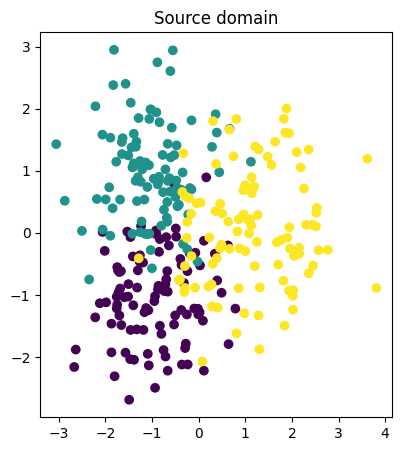

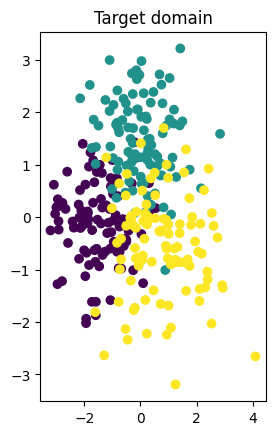

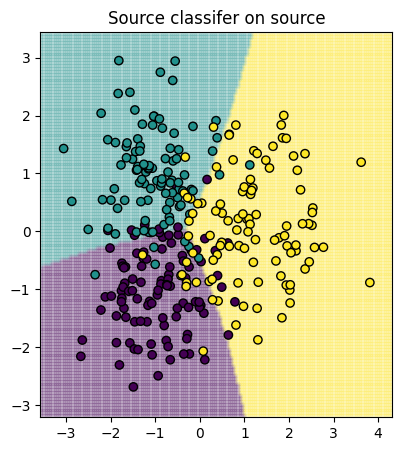

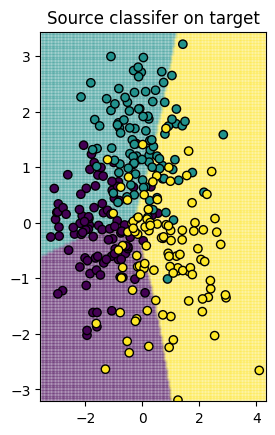

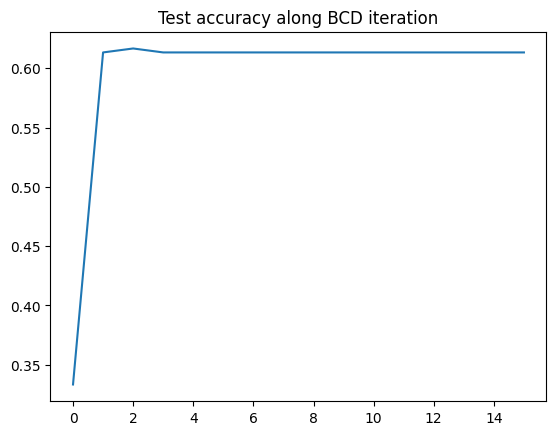

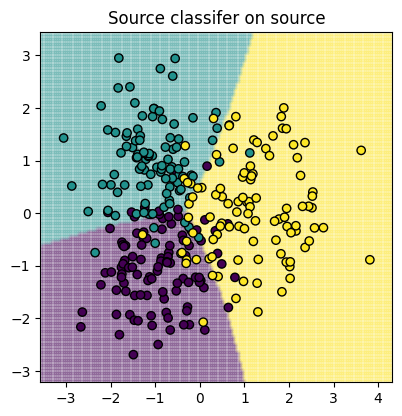

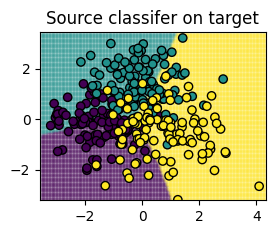

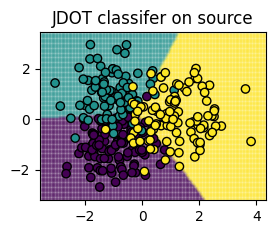

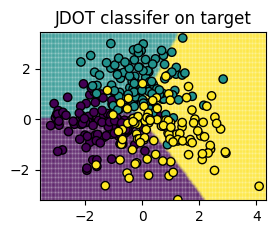

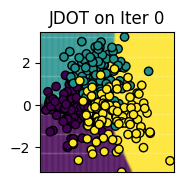

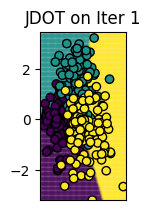

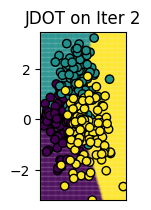

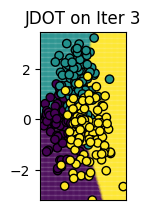

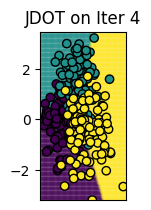

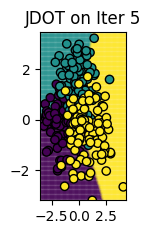

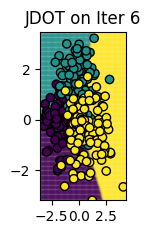

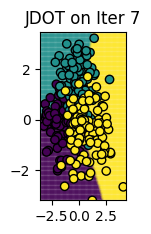

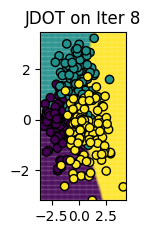

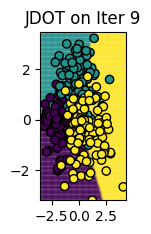

<Figure size 640x480 with 0 Axes>

In [ ]:

# -*- coding: utf-8 -*-
"""
Classification example for JDOT
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#         Nicolas Courty <ncourty@irisa.fr>
#
# License: MIT License

import numpy as np
import pylab as pl
import ot
import jdot
#from sklearn import datasets
import classif
import os
os.makedirs('/content/imgs', exist_ok=True) #Ajout pour créer le dossier '/content/imgs'




#%% data generation

seed=1985
np.random.seed(seed)

n = 300
ntest=300
nz=.3

theta=0.7

dataset='3gauss'
X,y=ot.datasets.get_data_classif(dataset,n,nz)

Xtest,ytest=ot.datasets.get_data_classif(dataset,ntest,nz)





print('Angle='+str(theta*180./np.pi))
rotation = np.array([[np.cos(theta),np.sin(theta)],
                          [-np.sin(theta),np.cos(theta)]])
#y[1:100]=2
Xtest=np.dot(Xtest,rotation.T)
#Xtest=Xtest2

nbnoise=0
if nbnoise:
    X=np.hstack((X,np.random.randn(n,nbnoise)))
    Xtest=np.hstack((Xtest,np.random.randn(ntest,nbnoise)))

Y,Yb=classif.get_label_matrix(y)

# visu grid
h=.05
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xfin=np.c_[xx.ravel(), yy.ravel()]

def plot_data_classif(X,y,Z=None):
    if not Z is None:
        pl.pcolormesh(xx, yy,np.argmax(Z,2),edgecolors='face',alpha=.1, vmin=0, vmax=2)
    pl.scatter(X[:,i1],X[:,i2],c=y,edgecolors='black')#,cmap='Pastel2')

def predict_test(clf,gamma,Xapp,Xtest):
    Kx=classif.rbf_kernel(Xtest,Xapp,gamma=gamma)
    return clf.predict(Kx)

def predict_test_grid(clf,gamma,Xapp):
    return predict_test(clf,gamma,Xapp,xfin).reshape((xx.shape[0],xx.shape[1],3))

#%% plot data
pl.figure(1,(10,5))


i1=0
i2=1;

pl.subplot(1,2,1)
pl.scatter(X[:,i1],X[:,i2],c=y)#,cmap='Pastel2')
pl.title('Source domain')
pl.show()

pl.subplot(1,2,2)
pl.scatter(Xtest[:,i1],Xtest[:,i2],c=ytest)#,cmap='Pastel2')
pl.title('Target domain')
pl.show()


#%% plot classifier on source

reg=1e-1
gamma=0.1#svm.estimGamma(Xtest)

clf=classif.SVMClassifier(reg)
K=classif.rbf_kernel(X,X,gamma=gamma)


clf.fit(K,Yb) # use binary matrix Y0

# visu
Z = predict_test_grid(clf,gamma,X)


pl.figure(2,(10,5))
pl.subplot(1,2,1)
plot_data_classif(X,y,Z)
pl.title('Source classifer on source')
pl.show()

pl.subplot(1,2,2)
plot_data_classif(Xtest,ytest,Z)
pl.title('Source classifer on target')
pl.show()

#%% plot Jdot

reg=1e1
itermax=15
gamma=0.1#svm.estimGamma(Xtest)

clf_jdot,dic= jdot.jdot_svm(X,Y,Xtest,ytest,gamma_g=gamma,numIterBCD = itermax, alpha=.1, lambd=reg,ktype='rbf')#,method='sinkhorn',reg=0.01)


# visu
Zj = predict_test_grid(clf_jdot,gamma,Xtest)

ypred=predict_test(clf_jdot,gamma,Xtest,Xtest)
TBR=np.mean(ytest==(ypred.argmax(1)+1))



pl.figure(3)

pl.plot(dic['TBR'])
pl.title('Test accuracy along BCD iteration')


pl.figure(4,(10,10))

pl.subplot(2,2,1)
plot_data_classif(X,y,Z)
pl.title('Source classifer on source')
pl.show()

pl.subplot(2,2,2)
plot_data_classif(Xtest,ytest,Z)
pl.title('Source classifer on target')
pl.show()

pl.subplot(2,2,3)
plot_data_classif(X,y,Zj)
pl.title('JDOT classifer on source')
pl.show()

pl.subplot(2,2,4)
plot_data_classif(Xtest,ytest,Zj)
pl.title('JDOT classifer on target')
pl.show()


#
#%% Display stuff
reg=1e1
gamma=0.1#svm.estimGamma(Xtest)
alpha=0.1

pl.figure(3,(10,4))

for i in range(10):
    clf_jdot,res = jdot.jdot_svm(X,Y,Xtest,ytest,gamma_g=gamma,numIterBCD = i+1, alpha=alpha, lambd=reg,ktype='rbf')#,method='sinkhorn',reg=0.01)
    Z = predict_test_grid(clf_jdot,gamma,Xtest)
    i1=0
    i2=1;
    #pl.figure(1,figsize=(5,5))
    #pl.clf()

    pl.subplot(2,5,i+1)


    plot_data_classif(Xtest,ytest,Z)
    pl.axis((x_min,x_max,y_min,y_max))
    pl.title('JDOT on Iter {}'.format(i))

    if i<5:
        pl.xticks(())

    pl.savefig('imgs/tlot_classif_{}.png'.format(i))#
    pl.savefig('imgs/visu_classif.png')
    pl.show()

pl.savefig('imgs/visu_classif.png')


In [ ]:
print("Dimensions de X:", X.shape)
print("Dimensions de y:", y.shape)
print("Dimensions de Xtest:", Xtest.shape)
print("Dimensions de ytest:", ytest.shape)


Dimensions de X: (300, 2)
Dimensions de y: (300,)
Dimensions de Xtest: (300, 2)
Dimensions de ytest: (300,)


## **Visualisation regression**

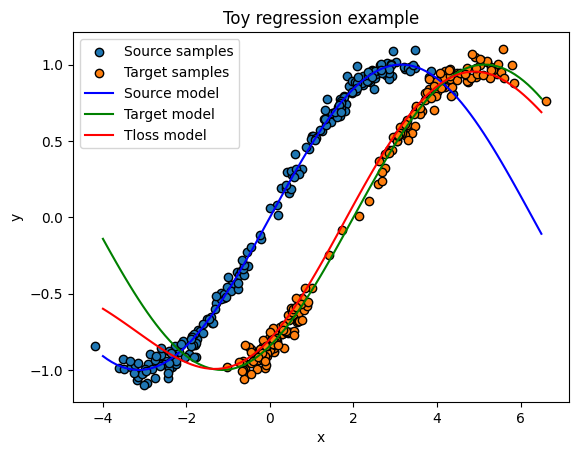

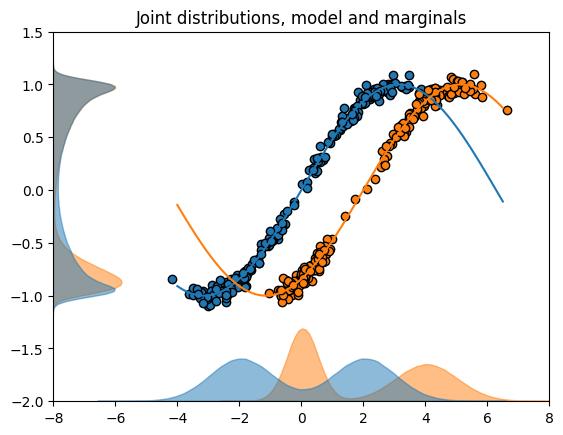

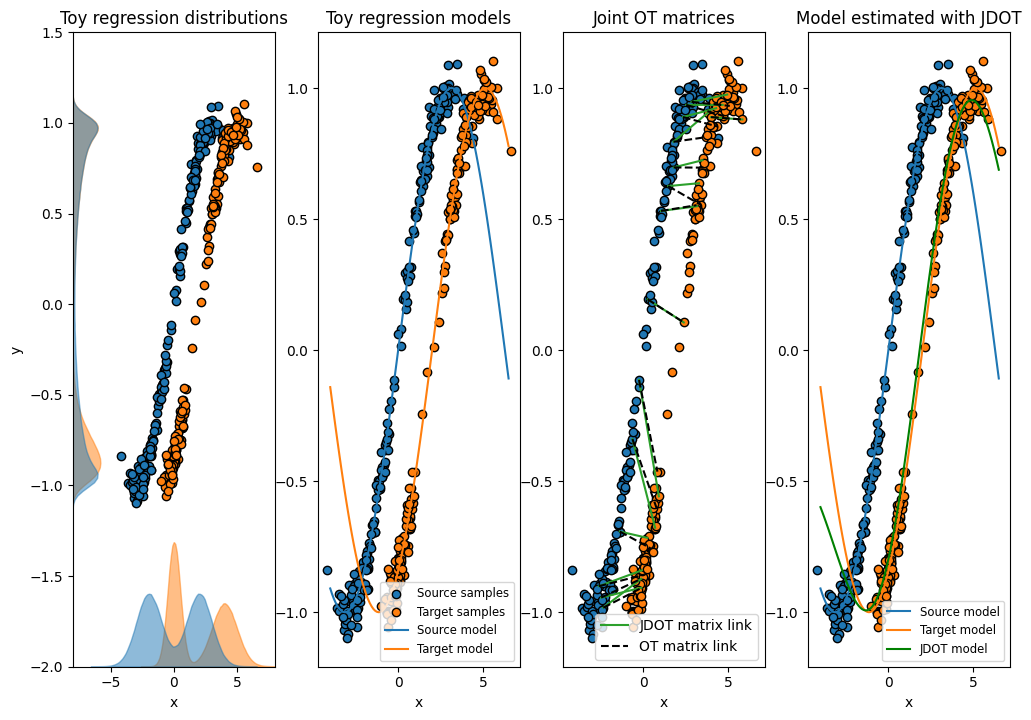

In [ ]:
# -*- coding: utf-8 -*-
"""
Regression example for JDOT
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#         Nicolas Courty <ncourty@irisa.fr>
#
# License: MIT License

import numpy as np
import pylab as pl

import jdot

#from sklearn import datasets
import sklearn
from scipy.spatial.distance import cdist
import ot


#%% data generation

seed=1985
np.random.seed(seed)

n = 200
ntest=200


def get_data(n,ntest):

    n2=int(n/2)
    sigma=0.05

    xs=np.random.randn(n,1)+2
    xs[:n2,:]-=4
    ys=sigma*np.random.randn(n,1)+np.sin(xs/2)



    xt=np.random.randn(n,1)+2
    xt[:n2,:]/=2
    xt[:n2,:]-=3

    yt=sigma*np.random.randn(n,1)+np.sin(xt/2)
    xt+=2

    return xs,ys,xt,yt

xs,ys,xt,yt=get_data(n,ntest)


fs_s = lambda x: np.sin(x/2)
fs_t = lambda x: np.sin((x-2)/2)


xvisu=np.linspace(-4,6.5,100)

pl.figure(1)
pl.clf()

pl.subplot()
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend()
pl.title('Toy regression example')
#pl.savefig('imgs/visu_data_reg.eps')

#%% TLOT
lambd0=1e1
itermax=15
gamma=1e-1
alpha=1e0/4
C0=cdist(xs,xt,metric='sqeuclidean')
#print np.max(C0)
C0=C0/np.median(C0)
fcost = cdist(ys,yt,metric='sqeuclidean')
C=alpha*C0+fcost
G0=ot.emd(ot.unif(n),ot.unif(n),C)

model,loss = jdot.jdot_krr(xs,ys,xt,gamma_g=gamma,numIterBCD = 10, alpha=alpha, lambd=lambd0,ktype='rbf')

K=sklearn.metrics.pairwise.rbf_kernel(xt,xt,gamma=gamma)
Kvisu=sklearn.metrics.pairwise.rbf_kernel(xvisu.reshape((-1,1)),xt,gamma=gamma)
ypred=model.predict(Kvisu)
ypred0=model.predict(K)


# compute true OT
C0=cdist(xs,xt,metric='sqeuclidean')
#print np.max(C0)
C0=C0/np.median(C0)
fcost = cdist(ys,ypred0,metric='sqeuclidean')
C=alpha*C0+fcost
G=ot.emd(ot.unif(n),ot.unif(n),C)


pl.figure(2)
pl.clf()
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
pl.plot(xvisu,ypred,'r',label='Tloss model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend()
pl.title('Toy regression example')


#%%
seed=1985
np.random.seed(seed)
idv=np.random.permutation(n)
fs=17
nb=15
pl.figure(3,(10,7))
pl.clf()

pl.subplot(2,2,1)
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),label='Source model')
pl.plot(xvisu,fs_t(xvisu),label='Target model')
#pl.xlabel('x')

pl.ylabel('y')
pl.legend(loc=4,fontsize=.7*fs)
pl.title('Toy regression example',fontsize=fs)

pl.subplot(2,2,2)
pl.scatter(xs,ys,edgecolors='k')
pl.scatter(xt,yt,edgecolors='k')
#pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
#pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
for i in range(nb):
    idt=G0[idv[i],:].argmax()
    if not i:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],'k',label='OT matrix link')
    else:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],'k')

#pl.xlabel('x')

pl.ylabel('y')
pl.legend(loc=4,fontsize=.7*fs)
pl.title('OT matrix on joint distribution',fontsize=fs)

pl.subplot(2,2,3)
pl.scatter(xs,ys,edgecolors='k')
pl.scatter(xt,yt,edgecolors='k')
#pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
#pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
for i in range(nb):
    idt=G[idv[i],:].argmax()

    pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],'k')

pl.xlabel('x')

pl.ylabel('y')
pl.legend(loc=4)
pl.title('OT matrix of JDOT',fontsize=fs)

pl.subplot(2,2,4)
pl.scatter(xs,ys,edgecolors='k')
pl.scatter(xt,yt,edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),label='Source model')
pl.plot(xvisu,fs_t(xvisu),label='Target model')
pl.plot(xvisu,ypred,'g',label='JDOT model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend(loc=4,fontsize=.7*fs)
pl.title('Model estimated with JDOT',fontsize=fs)

pl.tight_layout()
#pl.savefig('imgs/visu_reg.eps')

#%% compute histograms

seed=1985
np.random.seed(seed)

n2 = 2000000
ntest2=2000000

xs2,ys2,xt2,yt2=get_data(n2,ntest2)

xvisu=np.linspace(-4,6.5,100)
nbin=100
hys,pos=np.histogram(ys2,nbin)
hyt,pot=np.histogram(yt2,nbin)

hxs,posx=np.histogram(xs2,nbin)
hxt,potx=np.histogram(xt2,nbin)


#%%

nbvisu=500

iss=np.random.permutation(n)[:nbvisu]
ist=np.random.permutation(ntest)[:nbvisu]
#

pl.figure(1)
pl.clf()

ym=-8
xm=-2

pl.scatter(xs[iss],ys[iss],edgecolors='k')
pl.scatter(xt[ist],yt[ist],edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),label='Source model')
pl.plot(xvisu,fs_t(xvisu),label='Target model')
pl.xlim([ym,8])
pl.ylim([xm,1.5])

sx=2.0/hys.max()


pl.fill(hyt*sx+ym,pot[1:],color='C1',alpha=0.5)
pl.fill(hys*sx+ym,pos[1:],color='C0',alpha=0.5)

sx2=0.4/hxs.max()


pl.fill(potx[1:],hxt*sx2+xm,color='C1',alpha=0.5)
pl.fill(posx[1:],hxs*sx2+xm,color='C0',alpha=0.5)

pl.title("Joint distributions, model and marginals")
pl.savefig('imgs/visu_data_reg.png')
#%%
seed=1985
np.random.seed(seed)
idv=np.random.permutation(n)
fs=12
nb=15
pl.figure(3,(12,3))
pl.clf()

pl.subplot(1,4,1)



ym=-8
xm=-2

pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
#pl.xlabel('x')
pl.xlabel('x')
pl.ylabel('y')


pl.xlim([ym,8])
pl.ylim([xm,1.5])

sx=2.0/hys.max()


pl.fill(hyt*sx+ym,pot[1:],color='C1',alpha=0.5)
pl.fill(hys*sx+ym,pos[1:],color='C0',alpha=0.5)

sx2=0.4/hxs.max()


pl.fill(potx[1:],hxt*sx2+xm,color='C1',alpha=0.5)
pl.fill(posx[1:],hxs*sx2+xm,color='C0',alpha=0.5)


#pl.legend(loc=4,fontsize=.7*fs)
pl.title('Toy regression distributions',fontsize=fs)

pl.subplot(1,4,2)
pl.scatter(xs,ys,edgecolors='k',label='Source samples')
pl.scatter(xt,yt,edgecolors='k',label='Target samples')
pl.plot(xvisu,fs_s(xvisu),color='C0',label='Source model')
pl.plot(xvisu,fs_t(xvisu),color='C1',label='Target model')


#pl.xlabel('x')

#pl.ylabel('y')
pl.legend(loc=4,fontsize=.7*fs)
pl.title('Toy regression models',fontsize=fs)
pl.xlabel('x')
pl.subplot(1,4,3)
pl.scatter(xs,ys,edgecolors='k')
pl.scatter(xt,yt,edgecolors='k')
#pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
#pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
for i in range(nb):
    idt=G[idv[i],:].argmax()
    if not i:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],color='C2',label='JDOT matrix link')
    else:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],color='C2')
for i in range(nb):
    idt=G0[idv[i],:].argmax()
    if not i:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],'k--',label='OT matrix link')
    else:
        pl.plot([xs[idv[i]],xt[idt]],[ys[idv[i]],yt[idt]],'k--')


pl.xlabel('x')

#pl.ylabel('y')
pl.legend(loc=4)
pl.title('Joint OT matrices',fontsize=fs)

pl.subplot(1,4,4)
pl.scatter(xs,ys,edgecolors='k')
pl.scatter(xt,yt,edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),label='Source model')
pl.plot(xvisu,fs_t(xvisu),label='Target model')
pl.plot(xvisu,ypred,'g',label='JDOT model')
pl.xlabel('x')

#pl.ylabel('y')
pl.legend(loc=4,fontsize=.7*fs)
pl.title('Model estimated with JDOT',fontsize=fs)

pl.tight_layout(pad=00,h_pad=0)
#pl.savefig('imgs/visu_reg2.eps')
pl.savefig('imgs/visu_reg2.pdf')
pl.savefig('imgs/visu_reg2.png')

## **Neural network regression**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4596  
Epoch 2/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 
Epoch 3/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 
Epoch 4/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 
Epoch 5/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 
Epoch 6/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 
Epoch 7/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 
Epoch 8/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 
Epoch 9/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 
Epoch 10/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 
Epoch 11/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 
Epoch 12/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 
Epoch 13/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 
Epoch 14/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 
Epoch 15/60
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 
Epoch 16/60
7/7 ━━━━━━━━━━━━━━━━━

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5709  
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1617 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0736 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964  
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1397 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0662 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

Text(0.5, 1.0, 'Toy regression example')

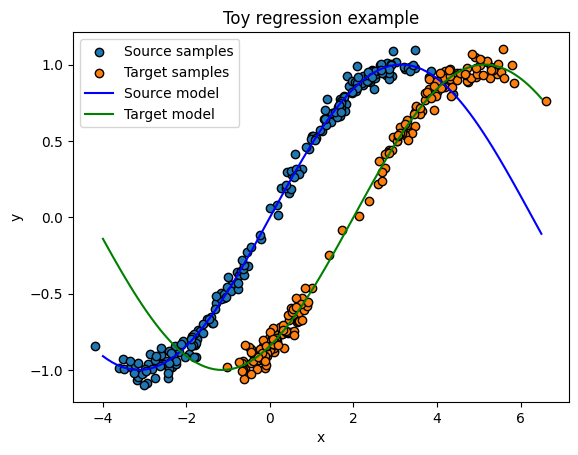

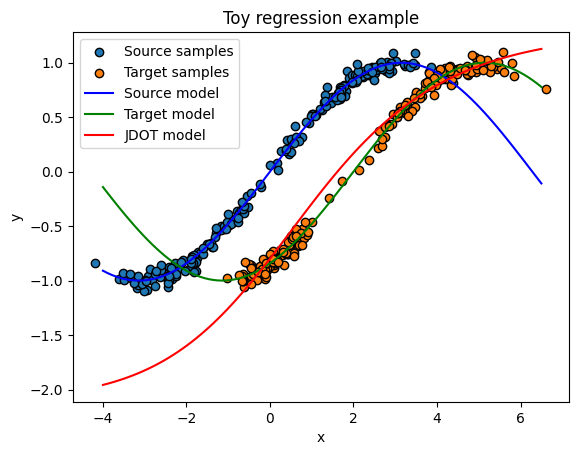

In [ ]:
# -*- coding: utf-8 -*-
"""
Neural network regression example for JDOT
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#         Nicolas Courty <ncourty@irisa.fr>
#
# License: MIT License


import numpy as np
import pylab as pl

import jdot

#from sklearn import datasets
from scipy.spatial.distance import cdist
import ot
import keras


#%% data generation

seed=1985
np.random.seed(seed)

n = 200
ntest=200
nz=.3

theta=0.7


n2=int(n/2)
sigma=0.05

xs=np.random.randn(n,1)+2
xs[:n2,:]-=4
ys=sigma*np.random.randn(n,1)+np.sin(xs/2)

fs_s = lambda x: np.sin(x/2)

xt=np.random.randn(n,1)+2
xt[:n2,:]/=2
xt[:n2,:]-=3

gauss = lambda x,s,m: np.exp((x-m)**2/(2*s*s))/(s*np.sqrt(2*np.pi))
mus_x = lambda x: gauss(x,1,2)/2+gauss(x,1,-2)/2


yt=sigma*np.random.randn(n,1)+np.sin(xt/2)
xt+=2

fs_t = lambda x: np.sin((x-2)/2)
mut_x = lambda x: gauss(x,1,2)/2+gauss(x,1./2,-4)/2

xvisu=np.linspace(-4,6.5,100)

pl.figure(1)
pl.clf()

pl.subplot()
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend()
pl.title('Toy regression example')
#pl.savefig('imgs/visu_data_reg.eps')


#%% learn on source

def get_model():
    # simple 1D nn
    model=keras.models.Sequential()
    model.add(keras.layers.Dense(100,activation='tanh',input_shape=(1,)))
    model.add(keras.layers.Dense(50,activation='tanh'))
    model.add(keras.layers.Dense(1,activation='linear'))

    model.compile('sgd','mse')

    return model

model=get_model()

fit_params={'epochs':60}

model.fit(xs,ys,**fit_params)
ypred=model.predict(xvisu)

pl.figure(2)
pl.clf()
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
pl.plot(xvisu,ypred,'r',label='Source estimated model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend()
pl.title('Toy regression example')

#%% TLOT

itermax=5
alpha=1
C0=cdist(xs,xt,metric='sqeuclidean')
#print np.max(C0)
C0=C0/np.median(C0)
fcost = cdist(ys,yt,metric='sqeuclidean')
C=alpha*C0+fcost
G0=ot.emd(ot.unif(n),ot.unif(n),C)

fit_params={'epochs':100}

model,loss = jdot.jdot_nn_l2(get_model,xs,ys,xt,ytest=yt,fit_params=fit_params,numIterBCD = itermax, alpha=alpha)

ypred=model.predict(xvisu.reshape((-1,1)))


pl.figure(2)
pl.clf()
pl.scatter(xs,ys,label='Source samples',edgecolors='k')
pl.scatter(xt,yt,label='Target samples',edgecolors='k')
pl.plot(xvisu,fs_s(xvisu),'b',label='Source model')
pl.plot(xvisu,fs_t(xvisu),'g',label='Target model')
pl.plot(xvisu,ypred,'r',label='JDOT model')
pl.xlabel('x')

pl.ylabel('y')
pl.legend()
pl.title('Toy regression example')

# **2- Dans cette deuxième partie je vais exécuter le code de Rémy sur le jeu de données Wine**

In [ ]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import ot
import jdot
import classif
import os

In [ ]:
os.makedirs('/content/imgs', exist_ok=True)  # Crée le dossier si besoin

Je charge le jeu de données wine et je réduis la dimension à 2 en utilisant l'ACP

In [ ]:
# Charger les données Wine et appliquer l'ACP
data = load_wine()
X = data.data
y = data.target

# Réduction de dimension avec l'ACP à 2 composantes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

Ensuite je divise le jeu de données réduit à 2 dimensions en deux de donnée de distribution différente et je fais une rotation de 45° sur le deuxième jeu de données.

In [ ]:
# Diviser le jeu de données en deux sous-ensembles
X_pca1, X_pca2, y1, y2 = train_test_split(X_pca, y, test_size=0.5, random_state=42)

# Appliquer une rotation sur le deuxième sous-ensemble
angle = np.pi / 4  # 45 degrés
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_pca2_transformed = X_pca2.dot(rotation_matrix)

In [ ]:
# Remplacer les anciennes données par les nouvelles
X, y = X_pca1, y1  # Données source
Xtest, ytest = X_pca2_transformed, y2  # Données cible (rotation appliquée)

# Préparer les labels pour le classifieur
Y, Yb = classif.get_label_matrix(y)

**Note:** J'ai dû réduire la valeur de **h** de 0.05 à 0.1 pour permettre au code de tourner sinon c'était impossible

In [ ]:
# Visualisation de la grille
h = 0.1
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
xfin = np.c_[xx.ravel(), yy.ravel()]

In [ ]:
def plot_data_classif(X, y, Z=None):
    if Z is not None:
        pl.pcolormesh(xx, yy, np.argmax(Z, 2), edgecolors='face', alpha=.1, vmin=0, vmax=2)
    pl.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black')

def predict_test(clf, gamma, Xapp, Xtest):
    Kx = classif.rbf_kernel(Xtest, Xapp, gamma=gamma)
    return clf.predict(Kx)

def predict_test_grid(clf, gamma, Xapp):
    return predict_test(clf, gamma, Xapp, xfin).reshape((xx.shape[0], xx.shape[1], 3))

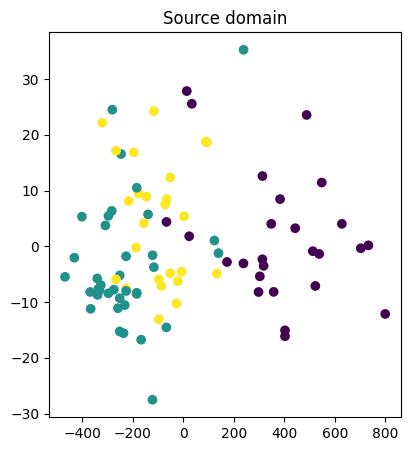

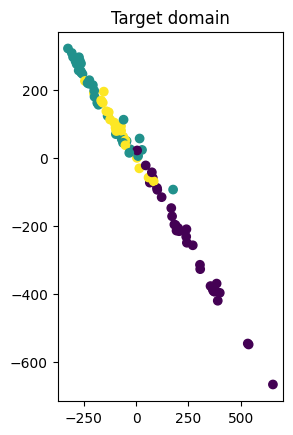

In [ ]:
# Visualiser les données
pl.figure(1, (10, 5))

pl.subplot(1, 2, 1)
pl.scatter(X[:, 0], X[:, 1], c=y)
pl.title('Source domain')
pl.show()

pl.subplot(1, 2, 2)
pl.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest)
pl.title('Target domain')
pl.show()

Je vais maintenant tenter d'appliquer la classe Classif  et JDOT (de Remy FLAMARY et Nicolas COURTY) pour transformer le deuxième sous-ensemble obtenue après rotation en un sous-ensemble de même distribution que le premier sous-ensemble

In [ ]:
# Entraîner le classifieur SVM sur le domaine source
reg = 1e-1
gamma = 0.1
clf = classif.SVMClassifier(reg)
K = classif.rbf_kernel(X, X, gamma=gamma)
clf.fit(K, Yb)

In [ ]:
#Visualisation des prédictions du classifieur
Z = predict_test_grid(clf, gamma, X)

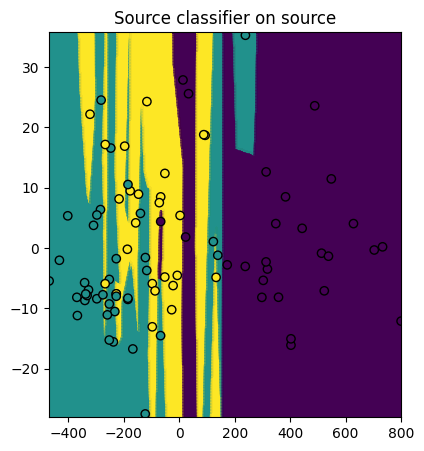

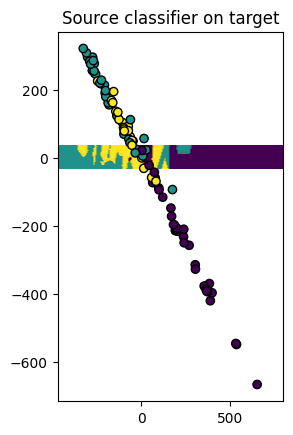

In [ ]:
# V
pl.figure(2, (10, 5))
pl.subplot(1, 2, 1)
plot_data_classif(X, y, Z)
pl.title('Source classifier on source')
pl.show()

pl.subplot(1, 2, 2)
plot_data_classif(Xtest, ytest, Z)
pl.title('Source classifier on target')
pl.show()


- Sur le graphique **Source Classifier on Source**, les points représentent les données réelles du domaine source, colorés selon leur classe réelle. On constate que la plupart des points sont bien classés, signifiant que le SVM fonctionne efficacement sur le domaine source.



- Sur le graphique **Source Classifier on Target**, on voit que les zones colorées ne correspondent pas bien aux classes réelles des points (coloration des points), montrant ainsi que la rotation a effectivement changé la distribution des données de manière significative par rapport à ce que le SVM a appris.


**JDOT** est appliqué sur plusieurs itérations. On peut essayer différentes valeurs des paramètres  **alpha** pour équilibrer les coûts de transport et  **lambd** pour la régularisation du SVM à l'intérieur de la fonction  **jdot_svm** de la classe **jdot**.

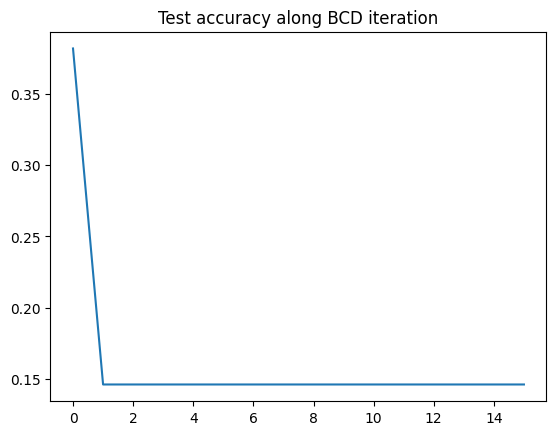

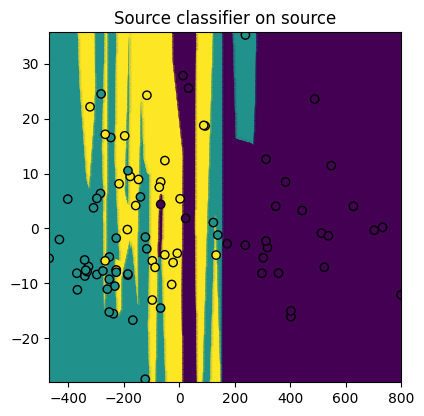

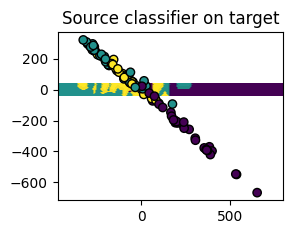

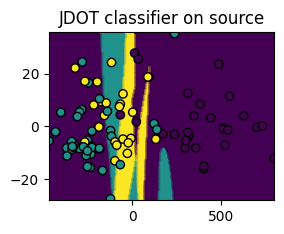

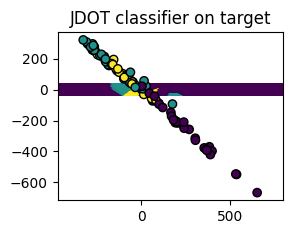

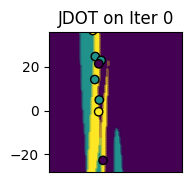

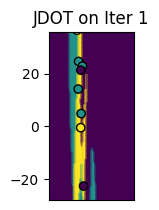

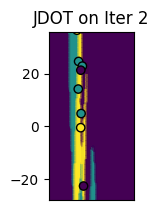

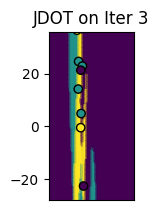

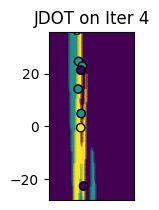

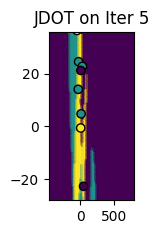

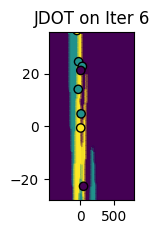

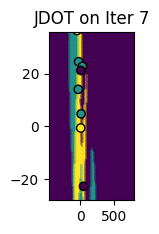

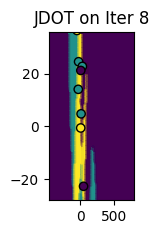

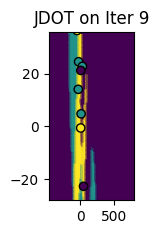

<Figure size 640x480 with 0 Axes>

In [ ]:

# Appliquer JDOT
reg = 1.5e1
itermax = 15
clf_jdot, dic = jdot.jdot_svm(X, Y, Xtest, ytest, gamma_g=gamma, numIterBCD=itermax, alpha=.1, lambd=reg, ktype='rbf')

# Visualiser les prédictions de JDOT
Zj = predict_test_grid(clf_jdot, gamma, Xtest)
ypred = predict_test(clf_jdot, gamma, Xtest, Xtest)
TBR = np.mean(ytest == (ypred.argmax(1) + 1))

pl.figure(3)
pl.plot(dic['TBR'])
pl.title('Test accuracy along BCD iteration')

pl.figure(4, (10, 10))

pl.subplot(2, 2, 1)
plot_data_classif(X, y, Z)
pl.title('Source classifier on source')
pl.show()

pl.subplot(2, 2, 2)
plot_data_classif(Xtest, ytest, Z)
pl.title('Source classifier on target')
pl.show()

pl.subplot(2, 2, 3)
plot_data_classif(X, y, Zj)
pl.title('JDOT classifier on source')
pl.show()

pl.subplot(2, 2, 4)
plot_data_classif(Xtest, ytest, Zj)
pl.title('JDOT classifier on target')
pl.show()

# Afficher les itérations de JDOT
alpha = 0.2
pl.figure(3, (10, 4))

for i in range(10):
    clf_jdot, res = jdot.jdot_svm(X, Y, Xtest, ytest, gamma_g=gamma, numIterBCD=i+1, alpha=alpha, lambd=reg, ktype='rbf')
    Z = predict_test_grid(clf_jdot, gamma, Xtest)

    pl.subplot(2, 5, i+1)
    plot_data_classif(Xtest, ytest, Z)
    pl.axis((x_min, x_max, y_min, y_max))
    pl.title(f'JDOT on Iter {i}')

    if i < 5:
        pl.xticks(())

    pl.savefig(f'imgs/tlot_classif_{i}.png')
    pl.show()

pl.savefig('imgs/visu_classif.png')


- Le premier graphique montre l'évolution de la précision du test à travers les itérations de JDOT. On observe une amélioration initiale rapide, puis une stabilisation. Cela suggère que les premières itérations sont cruciales pour l'adaptation du modèle.

- La classification se fait assez bien sur les données source, mais moin bien dans le domaine cible.

- A partir de "JDOT on Iter 2" jusqu'à "JDOT on Iter 9", on observe la même figure ce qui est cohérent avec la figure "Test on accuracy along BCD iteration."

-  La visualisation montre comment notre classifieur, bien qu'il performe bien sur les données source, ne s'adapte pas efficacement au domaine cible à cause de la rotation.

- La comparaison entre les figures avant et après l'application de JDOT ne montre pas une amélioration notable de la généralisation du classifieur au domaine cible.